## Compare data to predictions
Look at confusion matrix, plot ROC curve and then calibration curve.

In [11]:
from standard_libs import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    add_text_features_to_df,
    get_vectorized_series,
    get_feature_vector_and_label
)

from ml_editor.model_evaluation import get_confusion_matrix_plot

In [13]:
data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

In [14]:
df = add_text_features_to_df(df.loc[df['is_question']].copy())
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=42)

We load the trained model and vectorizer

In [15]:
model_path = Path('../models/model_1.pkl')
clf = joblib.load(model_path)
vectorizer_path = Path('../models/vectorizer_1.pkl')
vectorizer = joblib.load(vectorizer_path)

We use the vectorizer on our data to produce features that are ready for the model

In [16]:
train_df['vectors'] = get_vectorized_series(train_df['full_text'].copy(), vectorizer)
test_df['vectors'] = get_vectorized_series(test_df['full_text'].copy(), vectorizer)

features = [
    "action_verb_full",
    "question_mark_full",
    "text_len",
    "language_question",
]

X_train, y_train = get_feature_vector_and_label(train_df, features)
X_test, y_test = get_feature_vector_and_label(test_df, features)

Finally, we get the model's predictions on a held out test set

In [17]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

### Confusion matrix

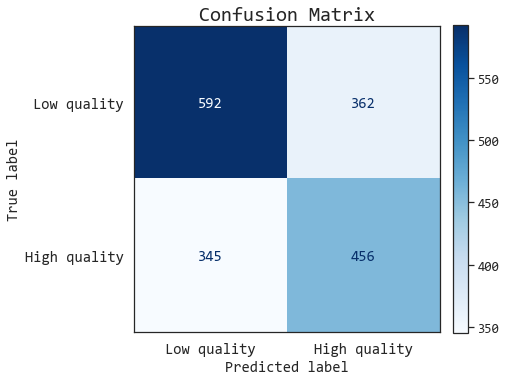

In [67]:
get_confusion_matrix_plot(y_pred, y_test, cmap='Blues', values_format='d', font_size=15, figsize=(6, 6));

## ROC Curve

In [68]:
from ml_editor.model_evaluation import get_roc_plot

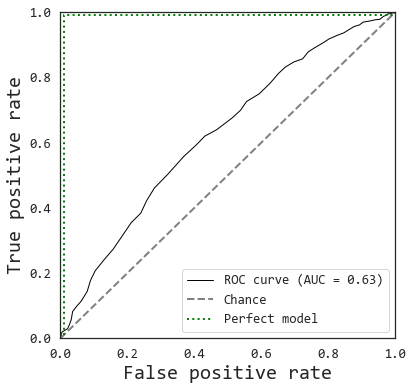

In [70]:
get_roc_plot(y_pred_proba[:, 1], y_test, figsize=(6, 6))

ROC curves can help judge the overall performance of a model, but most models are designed with practical applications in mind. These applications often come with specific performance requirements, such as maintaining false positives below a certain rate. To understand model performance better, it can be helpful to highlight the relevant part of an ROC curve.

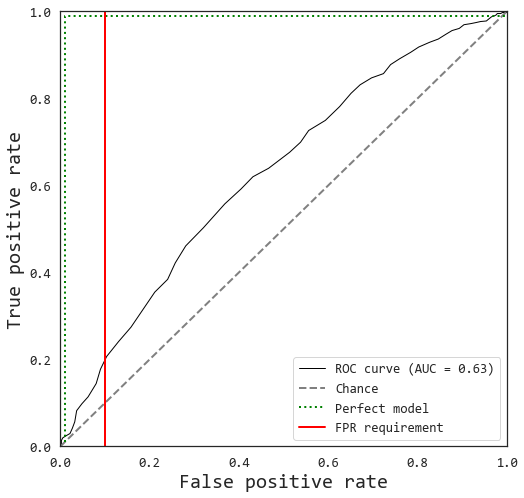

In [71]:
get_roc_plot(y_pred_proba[:, 1], y_test, fpr_bar=.1, figsize=(8, 8))

### Calibration Curve
Finally, we'll plot a calibration curve, which plots the fraction of actual positive examples as a function of a model's probability score. Such a curve allows us to measure the quality of a model's probability estimabe (when a model says a question has a 60% chance to be good, is that actually the case?)

In [9]:
from ml_editor.model_evaluation import get_calibration_plot

No handles with labels found to put in legend.


	Brier: 0.237


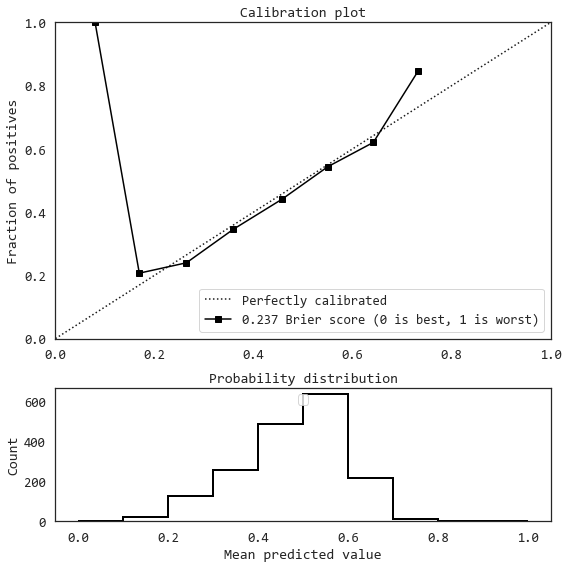

In [10]:
get_calibration_plot(y_pred_proba[:, 1], y_test, figsize=(8, 8));

On this plot, we can see that the model is well calibrated between 0.2 and 0.7, and poorly outside that. This is in part due to the fact the model mostly outputs scores between 0.2 and 0.7 from the histogram. The Brier score is a measure of the calibration ranging from 0 to 1, with a value of 0 meaning the model is perfectly calibrated.

To gain an even better understanding of success and failure modes of our model, we can examine individual examples to identify error trends.